## This notebook is about performoing clustering using a mixed data : Categorical and numerical values

K-prototype method

In [1]:
### Import Statements

In [3]:

import random
import math

import numpy as np
import pandas as pd

import umap
import umap.plot as uplot

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples

from kneed import KneeLocator

from kmodes.kprototypes import KPrototypes
import gower

from numba import njit

random.seed(42)
sns.set_theme()

## Dataset description

The Telco Churn Dataset is a customer behavior dataset that includes information about a telecommunications company's customers and whether or not they discontinued their services within the last month (churned). The dataset is typically used to create predictive models to identify customers who are likely to churn in the future.

- **customerID**: This is a unique identifier for each customer in the dataset.

- **gender**: This indicates the gender of the customer, typically "Male" or "Female".
- **SeniorCitizen**: This is a binary indicator of whether the customer is a senior citizen or not.
- **Partner**: This is a binary indicator of whether the customer has a partner or not.
- **Dependents**: This is a binary indicator of whether the customer has any dependents or not.
- **tenure**: This represents the number of months the customer has been with the company.
- **PhoneService**: This is a binary indicator of whether the customer has a phone service or not.
- **MultipleLines**: This indicates whether the customer has multiple telephone lines.
- **InternetService**: This describes the type of internet service the customer has, typically DSL, Fiber optic, or None.
- **OnlineSecurity**: This is a binary indicator of whether the customer has online security services or not.
- **OnlineBackup**: This is a binary indicator of whether the customer has online backup services or not.
- **DeviceProtection**: This is a binary indicator of whether the customer has device protection services or not.
- **TechSupport**: This is a binary indicator of whether the customer has technical support services or not.
- **StreamingTV**: This is a binary indicator of whether the customer has streaming TV services or not.
- **StreamingMovies**: This is a binary indicator of whether the customer has streaming movie services or not.
- **Contract**: This describes the type of contract the customer has with the company, typically Month-to-month, One year, or Two year.
- **PaperlessBilling**: This is a binary indicator of whether the customer has opted for paperless billing or not.
- **PaymentMethod**: This describes the payment method that the customer uses, such as Electronic check, Mailed check, Bank transfer (automatic), or Credit card (automatic).
- **MonthlyCharges**: This represents the amount charged to the customer monthly.
- **TotalCharges**: This represents the total amount charged to the customer.
- **Churn**: This is a binary indicator of whether the customer churned (discontinued their services) in the last month or not.

Citation : IBM Sample Data Sets - Telco customer churn

# Load And Preprocess The Data 

In [4]:
# Load the data
telco_path = 'Telco-Customer-Churn.csv'
telco_df = pd.read_csv(telco_path)


In [5]:
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
telco_df = telco_df.drop_duplicates().reset_index(drop=True)

In [7]:
telco_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [8]:
# Dataset shape
telco_df.shape

(7043, 21)

In [9]:
# Check for missing values
telco_df.isnull().sum(axis=0)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
# Columns data type
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
#Converting the data type of SeniorCitizen from int to object
telco_df['SeniorCitizen'] = telco_df['SeniorCitizen'].astype(int).astype('object')

In [12]:
# Columns data type
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [13]:
# Remove rows with non existing TotalCharges
telco_df = telco_df[telco_df['TotalCharges']!=' ']
telco_df['TotalCharges'] = telco_df['TotalCharges'].astype(float)   

/var/folders/h2/hlt0n3hj3jx4phv5m7ncq2180000gn/T/ipykernel_2413/4191256923.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telco_df['TotalCharges'] = telco_df['TotalCharges'].astype(float)


In [14]:
telco_df.shape

(7032, 21)

In [15]:
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
# Get copy of dataframe in order to preserve original values for cluster analysis
original_df = telco_df.copy()

In [17]:
# Remove columns that will not be used for clustering
other_cols = ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']
other_df = telco_df.loc[:, other_cols]
telco_df = telco_df.dropna().drop(columns=other_cols)

This snippet prepares the `telco_df` DataFrame for clustering by removing columns not relevant to the clustering process. 
---

### **Step-by-Step Explanation**

1. **Identify Columns to Exclude**  
   ```python
   other_cols = ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']
   ```
   - These columns (`other_cols`) are not deemed useful for clustering because:
     - **`customerID`**: Unique identifier; it does not provide meaningful information for clustering.
     - **`Churn`**: A target label for classification, not a feature for clustering.
     - **`gender`, `SeniorCitizen`, `Partner`, `Dependents`**: These are likely categorical and might not be needed for the clustering objectives or could be processed separately.

---

2. **Preserve Columns for Potential Use Elsewhere**  
   ```python
   other_df = telco_df.loc[:, other_cols]
   ```
   - A subset of the DataFrame containing only the excluded columns is saved in `other_df`.  
   - **Why?**  
     - To retain this information for analysis or other tasks like visualization or post-clustering validation.

---

3. **Remove Missing Values and Unused Columns**  
   ```python
   telco_df = telco_df.dropna().drop(columns=other_cols)
   ```
   - **`dropna()`**: Removes rows with any missing values.
     - Ensures the dataset is clean and complete for clustering, as most clustering algorithms do not handle missing data.
   - **`drop(columns=other_cols)`**: Drops the columns listed in `other_cols` from `telco_df`.
     - Retains only the features relevant to clustering.

---


In [18]:
# Describe numerical attributes of the data
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


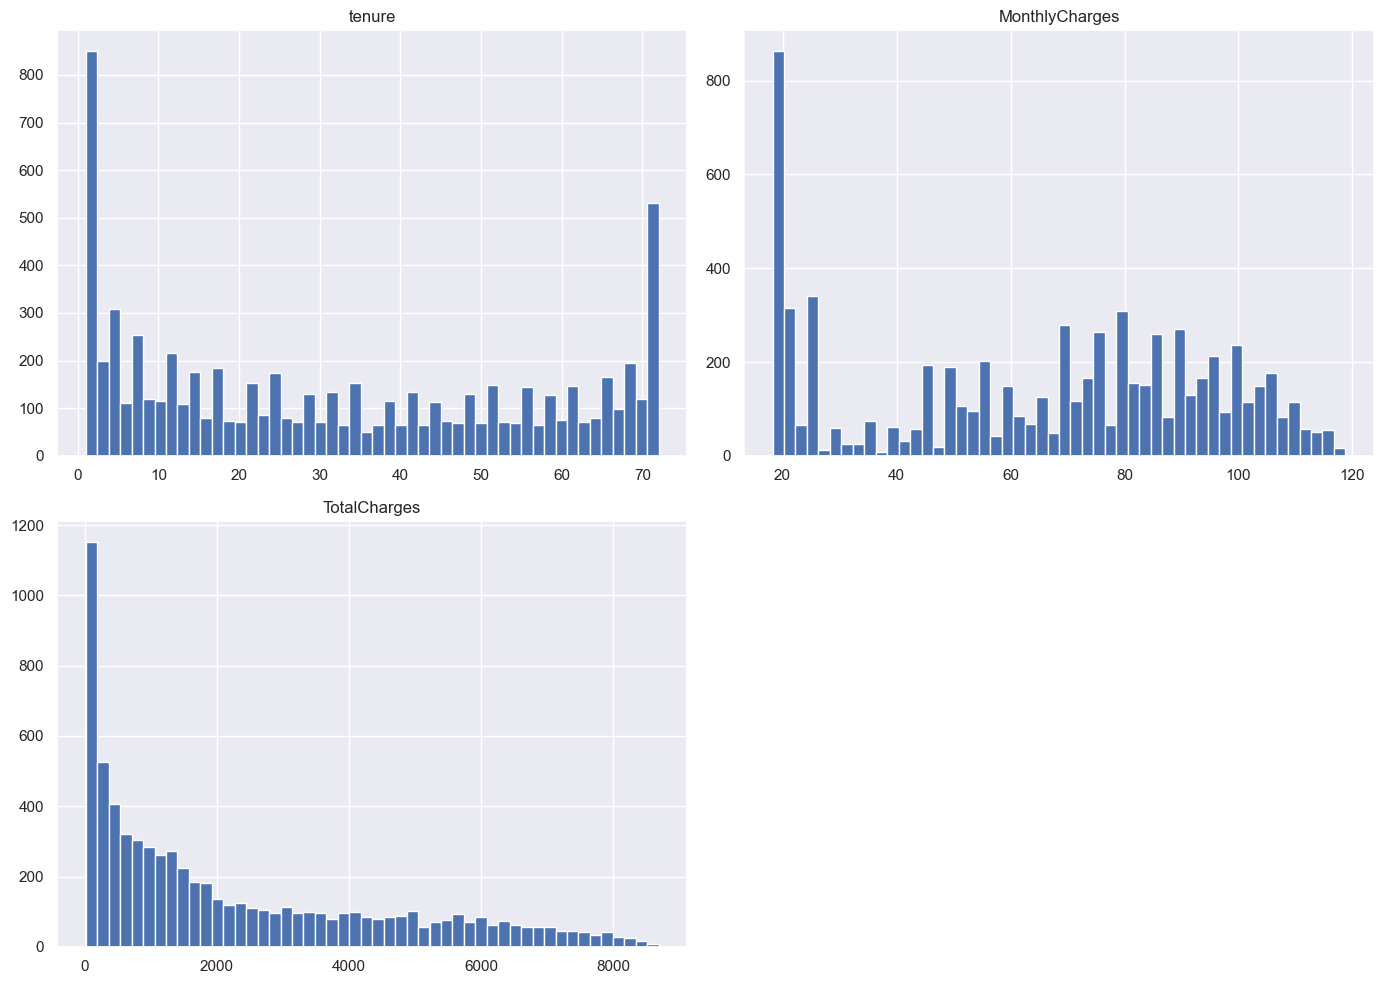

In [19]:
# Plot numerical variables
_ = telco_df.hist(bins=50, figsize=(14,10))

# This ensures the subplots do not overlap
plt.tight_layout()  
plt.show()


### **Step-by-Step Explanation**

1. **Plotting Histograms for Numerical Variables**
   ```python
   _ = telco_df.hist(bins=50, figsize=(14, 10))
   ```
   - **`telco_df.hist()`**: This method generates histograms for all numerical columns in `telco_df`.
     - **`bins=50`**: This specifies the number of bins (intervals) for the histogram. More bins offer a finer view of the distribution.
     - **`figsize=(14, 10)`**: This sets the size of the figure for the plots, ensuring they are large enough to interpret easily.

   - **Note**: The underscore `_` is commonly used to indicate that the result is intentionally ignored. The `hist()` method returns a `matplotlib` `Axes` object, but it's not needed here because the goal is simply to display the plots.

---

2. **Ensuring Subplots Don't Overlap**
   ```python
   plt.tight_layout()
   ```
   - **`plt.tight_layout()`**: This adjusts the spacing between the subplots to prevent overlap. It ensures that axis labels, titles, and other elements do not crowd each other, making the plots clearer.

---

3. **Displaying the Plot**
   ```python
   plt.show()
   ```
   - **`plt.show()`**: This function renders and displays the figure with the histograms.

---



In [20]:
# The distribution of the numerical data shows that they are skew to the right

In the context of histograms, **bins** represent the intervals or "buckets" into which data is grouped. Each bin holds a range of values, and the height of the bin shows how many data points (or observations) fall within that range.

### **Understanding Bins in Detail**

1. **Definition**: 
   - A **bin** is an interval that groups a set of continuous data into a range. When you plot a histogram, you're counting how many data points fall into each bin.
   - For example, if you have a dataset of ages and you decide to use bins of width 10 years, you might have bins like:
     - 0-10 years
     - 11-20 years
     - 21-30 years
     - And so on.

2. **Bins and Frequency**:
   - The **height** of a bin in a histogram shows the **frequency** or **count** of data points that fall within the range of that bin.
   - The wider the bin (i.e., the larger the interval), the fewer the number of bins, and vice versa. Narrower bins show more detail but can make the histogram look noisy.

3. **Effect of the Number of Bins**:
   - **Too few bins**: If there are too few bins (for example, just 2 or 3), the histogram will be overly generalized and you may miss key patterns in the data.
   - **Too many bins**: If there are too many bins (for example, hundreds), the histogram might look overly detailed, and the noise could obscure the actual distribution.

### **Real-World Example**
Imagine you have data on people's ages in a city:
```
[25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
```
If you choose **bins of width 10 years**, you might get the following ranges:
- 20-30 years
- 30-40 years
- 40-50 years
- 50-60 years
- 60-70 years
- 70-80 years

The histogram will then display how many people fall into each of these age ranges (bins).

### **Example in Python**:
Here’s how you might use bins in a histogram:
```python
import matplotlib.pyplot as plt

# Sample data
data = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

# Create histogram with 5 bins
plt.hist(data, bins=5)
plt.show()
```
- In this case, `bins=5` would mean the data is divided into 5 intervals. The number of people in each interval will determine the height of each bin in the histogram.

### **Choosing the Right Number of Bins**:
There’s no universal rule for how many bins to choose, but common methods include:
- **Sturges' Formula**: \( k = 1 + 3.322 \log N \), where \( N \) is the number of data points, and \( k \) is the number of bins.
- **Freedman-Diaconis Rule**: Uses interquartile range and is more robust against outliers.
- **Square Root Choice**: Simply \( k = \sqrt{N} \).



In [21]:
telco_df['TotalCharges'].skew()

0.9616424997242504

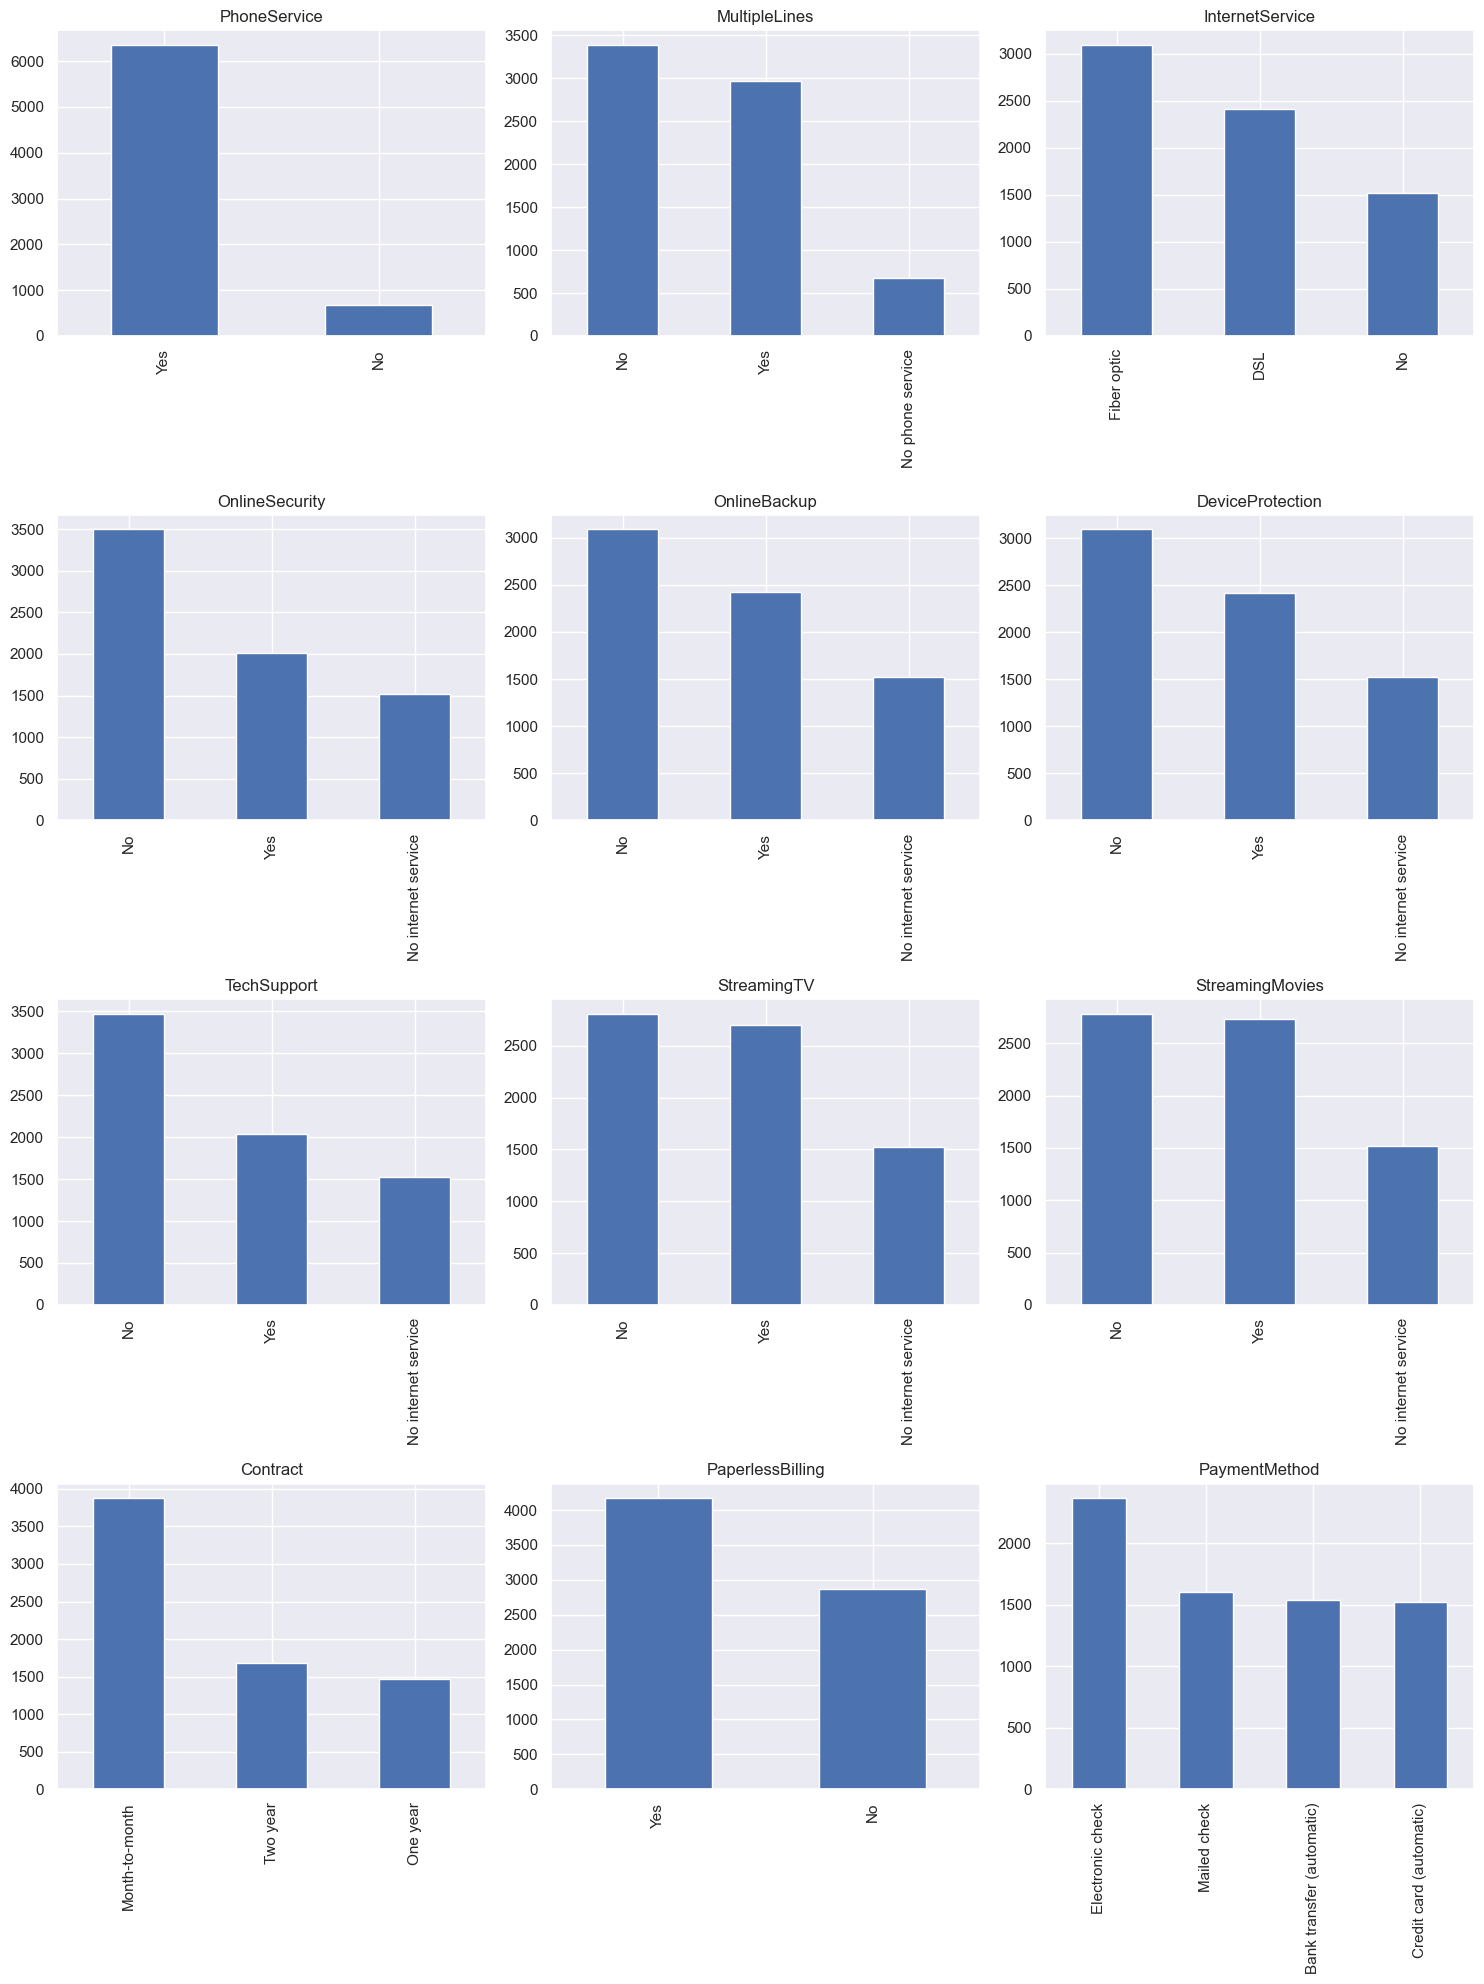

In [22]:
# Plot categorical columns
categ_cols = telco_df.select_dtypes(include=['object']).columns
num_plots = len(categ_cols)

# Determine number of rows needed for the grid
num_rows = math.ceil(num_plots / 3.0)

# Create subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Flatten the axes array if there's more than one row
axs = axs.flatten()

# Plot data
for i, column in enumerate(categ_cols):
    ax = axs[i] 
    telco_df[column].value_counts().plot(
        kind='bar', 
        ax=ax, 
        title=column, 
        xlabel=''
    )

plt.tight_layout()

In [23]:
# Get numerical and categorical columns
num_cols = list(set(telco_df.columns)-set(categ_cols))

# Scale numerical columns
telco_df['TotalCharges'] = np.sqrt(telco_df['TotalCharges'])

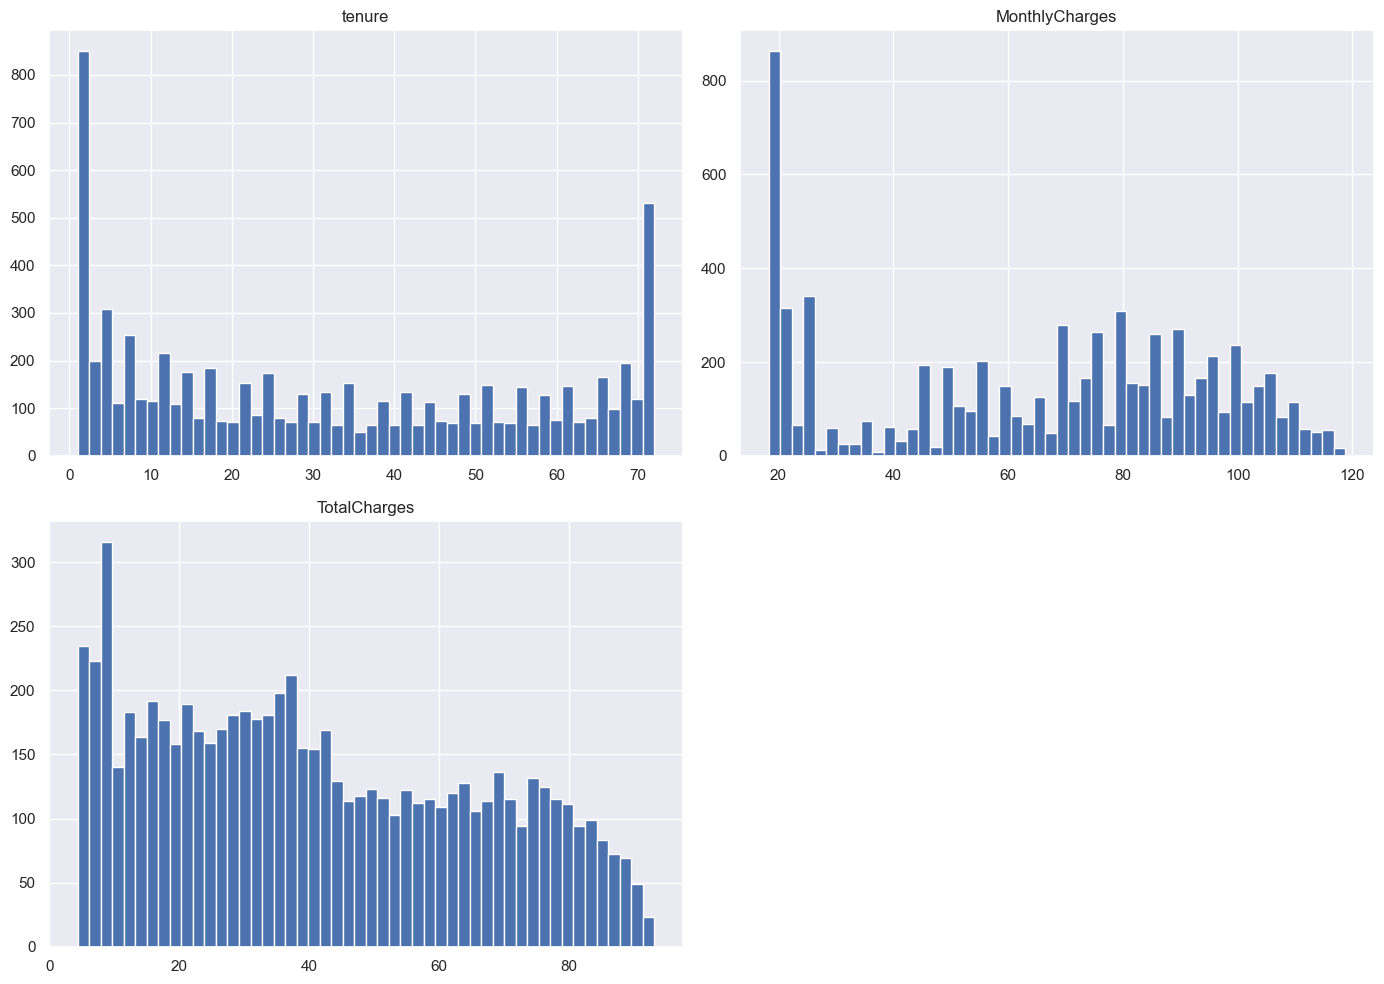

In [24]:
# Plot numerical variables
_ = telco_df.hist(bins=50, figsize=(14,10))

# This line ensures the subplots do not overlap
plt.tight_layout()  
plt.show()

In [25]:
# Scale numerical columns
standard_scaler = MinMaxScaler()
telco_df[num_cols] = standard_scaler.fit_transform(telco_df[num_cols])

# Encode categorical columns
ord_encoder = OrdinalEncoder(dtype=np.int32)
telco_df[categ_cols] = ord_encoder.fit_transform(telco_df[categ_cols])

In [26]:
telco_df.head()

,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0.000000,0,1,0,0,2,0,0,0,0,0,1,2,0.115423,0.012690
1,0.464789,1,0,0,2,0,2,0,0,0,1,0,3,0.385075,0.440402
2,0.014085,1,0,0,2,2,0,0,0,0,0,1,3,0.354229,0.068241
3,0.619718,0,1,0,2,0,2,2,0,0,1,0,0,0.239303,0.434049
4,0.014085,1,0,1,0,0,0,0,0,0,0,1,2,0.521891,0.089794


In [27]:
# Get positions of categorical and numerical columns
df_cols = list(telco_df.columns)

numerical_idx = np.array(
    [idx for idx, element in enumerate(df_cols) if element in num_cols]
)

categ_idx = np.array(
    [idx for idx, element in enumerate(df_cols) if element in categ_cols]
)

categ_bool = [True if element in categ_cols else False for element in df_cols]

UMAP Method


In [28]:
pairwise_gower = gower.gower_matrix(telco_df, cat_features=categ_bool)

In [29]:
pairwise_gower

array([[0.        , 0.6108101 , 0.2872294 , ..., 0.1527547 , 0.37474063,
        0.9026203 ],
       [0.6108101 , 0.        , 0.3235807 , ..., 0.4583871 , 0.45922038,
        0.55847687],
       [0.2872294 , 0.3235807 , 0.        , ..., 0.29736608, 0.28751126,
        0.68205756],
       ...,
       [0.1527547 , 0.4583871 , 0.29736608, ..., 0.        , 0.37045187,
        0.7501973 ],
       [0.37474063, 0.45922038, 0.28751126, ..., 0.37045187, 0.        ,
        0.661213  ],
       [0.9026203 , 0.55847687, 0.68205756, ..., 0.7501973 , 0.661213  ,
        0.        ]], dtype=float32)

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGB

<Axes: >

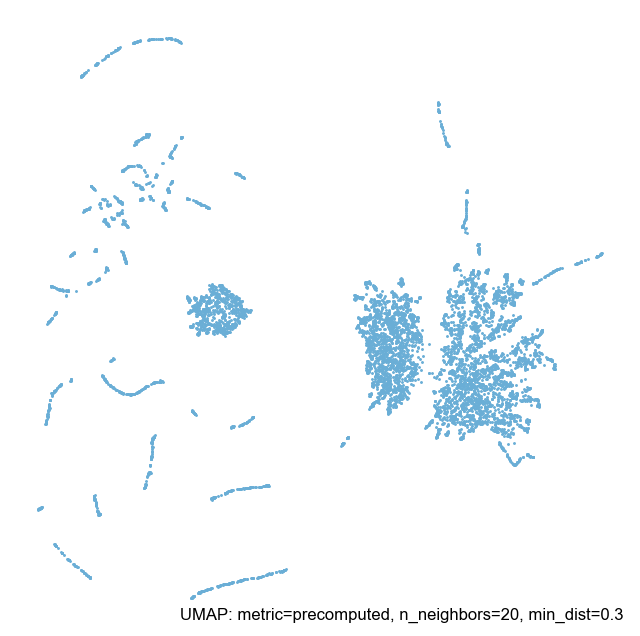

In [30]:
# Embed with umap
umap_model = umap.UMAP(
    n_neighbors=20, 
    n_components=2, 
    random_state=42, 
    metric='precomputed', 
    min_dist=0.3
)
umap_emb_data = umap_model.fit_transform(pairwise_gower)

uplot.points(umap_model)

<Axes: >

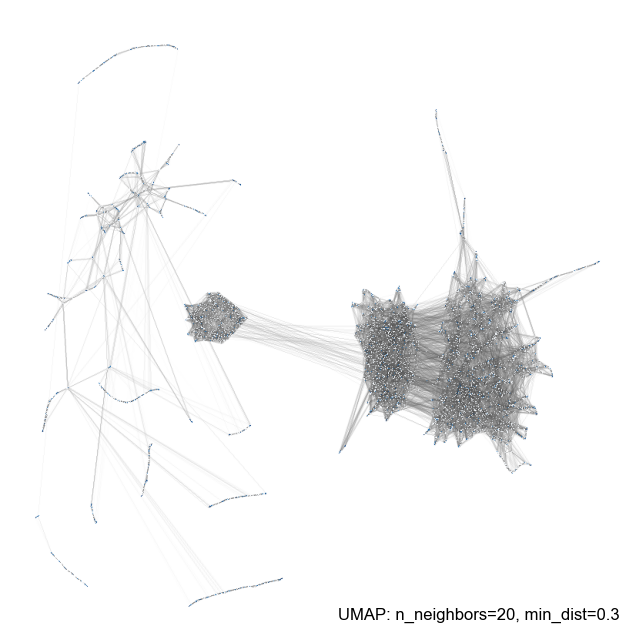

In [31]:
umap.plot.connectivity(umap_model, show_points=True)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

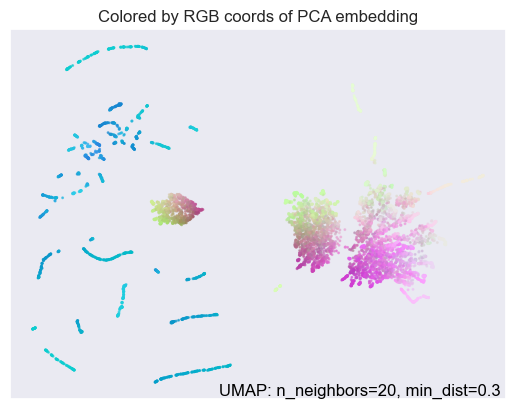

In [32]:
umap.plot.diagnostic(umap_model, diagnostic_type='pca')

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGB

<Axes: >

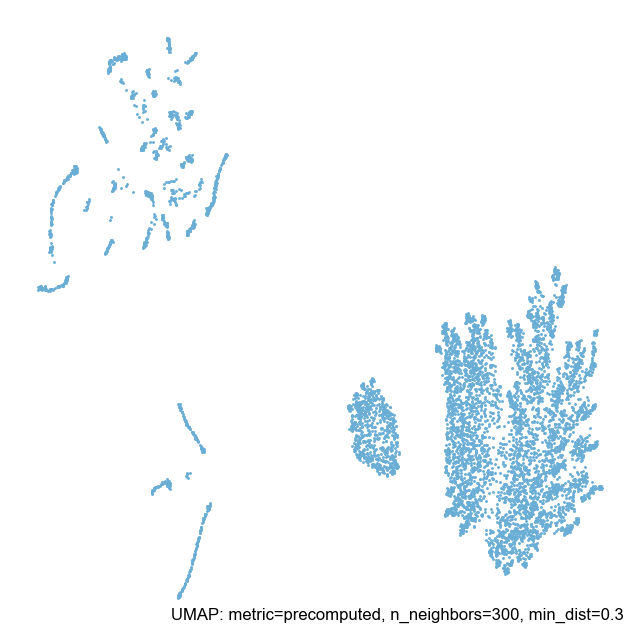

In [33]:
# Embed with umap
umap_model = umap.UMAP(
    n_neighbors=300, 
    n_components=2, 
    random_state=42, 
    metric='precomputed', 
    min_dist=0.3
)
umap_emb_data = umap_model.fit_transform(pairwise_gower)

uplot.points(umap_model)

<Axes: >

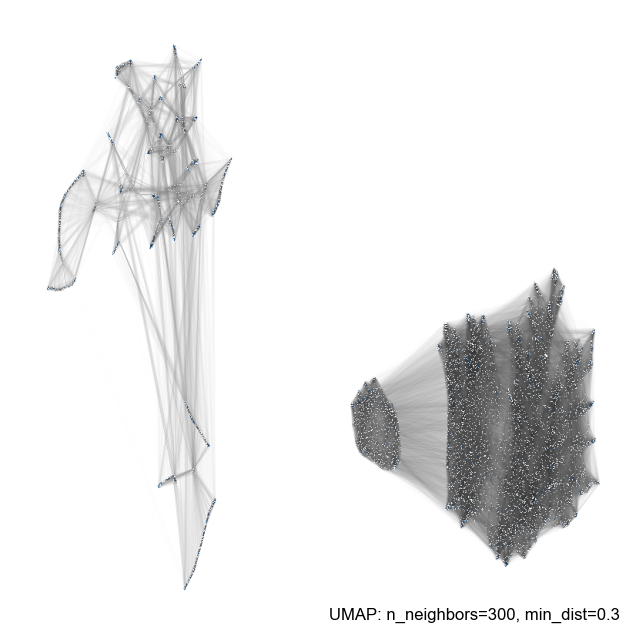

In [34]:
umap.plot.connectivity(umap_model, show_points=True)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

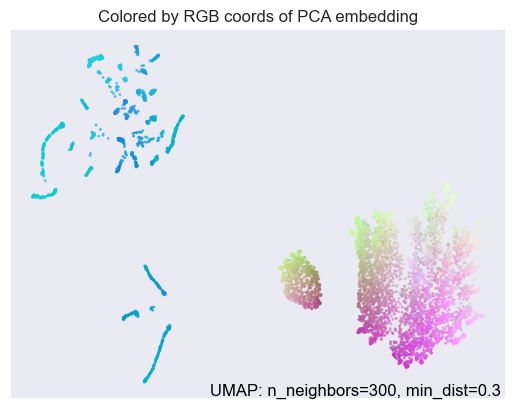

In [35]:
umap.plot.diagnostic(umap_model, diagnostic_type='pca')

### Mixed distance and k-prototypes

In [36]:
gamma = 1/2 * telco_df[num_cols].std().mean()
gamma

0.15354419462541744

In [37]:
def kproto_dist(x, y, num_idx, categ_idx, gamma):
    
    euclidean_part = np.sum(np.square(x[num_idx] - y[num_idx]))
    hamming_part = np.sum(x[categ_idx] == y[categ_idx])
    
    return euclidean_part + gamma*hamming_part

The function `kproto_dist(x, y, num_idx, categ_idx, gamma)` computes a distance metric between two data points, `x` and `y`, that includes both numerical and categorical features. This type of distance metric is often used in **K-prototype clustering**, which is a variation of the K-means algorithm that can handle both numerical and categorical data.

### **Explanation:**

- **Input parameters:**
  - `x`, `y`: These are the two data points (vectors) between which the distance is calculated.
  - `num_idx`: A list or array containing the indices of the numerical columns (features) in the data.
  - `categ_idx`: A list or array containing the indices of the categorical columns (features) in the data.
  - `gamma`: A scaling factor for the categorical part of the distance metric (used to balance the contribution of categorical and numerical distances).

- **Distance computation:**
  - **Euclidean distance for numerical features (`euclidean_part`):**
    - For the numerical features, the function computes the squared differences between the corresponding values of `x` and `y`, then sums them up to calculate the Euclidean distance.
    - This is done for the indices provided in `num_idx`:
      ```python
      euclidean_part = np.sum(np.square(x[num_idx] - y[num_idx]))
      ```
  
  - **Hamming distance for categorical features (`hamming_part`):**
    - The Hamming distance measures how many categorical features are different between `x` and `y`. In the case of categorical features, the distance is 1 if the values are different and 0 if they are the same.
    - This is computed by comparing the values of `x` and `y` for the columns in `categ_idx`:
      ```python
      hamming_part = np.sum(x[categ_idx] == y[categ_idx])
      ```
  
  - **Total distance:**
    - The final distance is a weighted sum of the Euclidean distance (numerical) and the Hamming distance (categorical). The Hamming distance is multiplied by the `gamma` factor, which controls how much influence the categorical distance has compared to the numerical distance:
      ```python
      return euclidean_part + gamma * hamming_part
      ```
  
### **How it works:**
- **Numerical distance (`euclidean_part`)**: The distance between `x` and `y` for the numerical features is computed using the standard Euclidean distance formula (sum of squared differences).
- **Categorical distance (`hamming_part`)**: The distance between `x` and `y` for the categorical features is computed by comparing if the values in `x` and `y` match. The result is a count of matching categories.
- **`gamma` scaling**: The final distance is a combination of the numerical and categorical distances, where `gamma` helps balance the relative weight of the categorical part. A higher value of `gamma` will give more weight to the categorical differences, while a smaller value will focus more on the numerical differences.

### **Use case:**
This function would be useful in algorithms like **K-prototype clustering**, where you need to handle datasets with both continuous (numerical) and discrete (categorical) features. By combining the Euclidean distance for numerical features with the Hamming distance for categorical features, you can compute a distance metric that respects both types of data.

In [38]:
@njit
def kproto_dist_nmb(x, y, num_idx, categ_idx, gamma):
    
    euclidean_part = 0
    for i in num_idx:
        euclidean_part += (x[i] - y[i]) ** 2

    hamming_part = 0
    for i in categ_idx:
        if x[i] != y[i]:
            hamming_part += 1

    return euclidean_part + gamma * hamming_part

The function `kproto_dist_nmb(x, y, num_idx, categ_idx, gamma)` is an optimized version of the `kproto_dist()` function, using **`@njit`** from **NumPy**'s `nopython` mode to compile the function into highly optimized machine code. This can lead to performance improvements, particularly for large datasets. 
### **Function Breakdown:**

1. **@njit decorator:**
   - The `@njit` decorator is from the **Numba** library and compiles Python functions to machine code, making them faster by removing the overhead of Python's dynamic nature.
   - `nopython=True` (which is the default in `@njit`) ensures the function is compiled without relying on Python's interpreter, further increasing performance. If any part of the code cannot be compiled, it will raise an error.

2. **Input parameters:**
   - `x`, `y`: These are the two data points (arrays or lists) between which the distance is computed.
   - `num_idx`: Indices of numerical features.
   - `categ_idx`: Indices of categorical features.
   - `gamma`: Scaling factor to balance the contribution of categorical and numerical distances.

3. **Euclidean distance for numerical features (`euclidean_part`):**
   - This part calculates the squared differences between `x` and `y` for each numerical feature in `num_idx`.
   - The loop iterates through each index in `num_idx`, computes the squared difference, and adds it to the running total `euclidean_part`:
     ```python
     euclidean_part += (x[i] - y[i]) ** 2
     ```

4. **Hamming distance for categorical features (`hamming_part`):**
   - This part calculates how many categorical features differ between `x` and `y`.
   - For each index in `categ_idx`, the function checks if the value at index `i` in `x` is different from `y`. If they are different, it increments the `hamming_part` by 1:
     ```python
     if x[i] != y[i]:
         hamming_part += 1
     ```

5. **Total distance:**
   - The total distance is the sum of the Euclidean part and the scaled Hamming part:
     ```python
     return euclidean_part + gamma * hamming_part
     ```

### **Optimizations in this version:**
- **Manual loops instead of NumPy operations**: In this version, the loops are manually written to iterate over the indices for numerical and categorical features. This makes the function simpler but might not be as efficient as using NumPy's vectorized operations, unless `@njit` significantly speeds up the loop execution.
- **`@njit` optimization**: By applying the `@njit` decorator, the function avoids the overhead of Python's interpreter during execution, which is beneficial for performance when computing distances over large datasets.

### **Use case and application:**
This version of the `kproto_dist` function is designed for use in **K-prototype clustering** or other algorithms where you need to compute the distance between mixed data (numerical and categorical) and you want to ensure the computation is as fast as possible for large datasets.

### **When to use:**
- When working with large datasets, the use of `@njit` will speed up the execution compared to the non-optimized version.
- If you're frequently computing distances for clustering algorithms (like K-prototypes) or distance matrices, this function can significantly improve the computation time.


This will compute the distance between the data points `x` and `y` using both their numerical and categorical features, with the categorical features being weighted by `gamma`.

### **Key Takeaways:**
- The `@njit` decorator optimizes the function, making it faster for large datasets.
- The function computes both **Euclidean distance** for numerical features and **Hamming distance** for categorical features.
- `gamma` balances the influence of categorical vs. numerical differences in the total distance.

This approach is particularly useful when applying mixed data clustering techniques like **K-prototype** clustering, where you need to calculate the distance between instances that contain both numerical and categorical features.

In [39]:
xx = telco_df.loc[0].to_numpy()
yy = telco_df.loc[1].to_numpy()

In [40]:
xx

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       2.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 2.        , 0.11542289, 0.01269035])

In [41]:
%%timeit
kproto_dist_nmb(xx,yy,num_idx=numerical_idx, categ_idx=categ_idx, gamma=gamma)

331 ns ± 4.26 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [42]:
%%timeit
kproto_dist(xx,yy,num_idx=numerical_idx, categ_idx=categ_idx, gamma=gamma)

3.06 μs ± 36.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [43]:
kproto_pairwise = pairwise_distances(
    telco_df.to_numpy(), metric=kproto_dist_nmb, 
    num_idx=numerical_idx, categ_idx=categ_idx, 
    gamma=gamma
)

In [44]:
def plot_silouethes_score(
    data, clusters, ax, colormap=None, 
    distance_measure='euclidean'
):
    
    y_lower = 10

    # Calculate average silhouette score
    silhouette_scr = silhouette_score(data, clusters, metric=distance_measure)
    
    # Calculate silhouette score for each data point
    sample_silhouette_values = silhouette_samples(data, clusters, metric=distance_measure)

    # Number of clusters
    num_clust = np.unique(clusters).shape[0]


    # Plot siluethe scores for points belonging to each cluster
    for clust_i in range(num_clust):
        
        # Get points bellogning to the current cluster
        ith_cluster_silhouette_values = sample_silhouette_values[
            clusters == clust_i
        ]
        
        # Sort points by silhouette value
        ith_cluster_silhouette_values.sort()
        
        # Get size of current cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        
        # Get upper value of y cooridnate for current cluster
        y_upper = y_lower + size_cluster_i
        
        # Fill values between y_lower and y_upper with silhouette score values
        # for data points

        if colormap:
            color = colormap[clust_i]
        else:
            color = cm.nipy_spectral(float(clust_i) / num_clust)

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(clust_i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    ax.axvline(x=silhouette_scr, color='r', linestyle='--')

    # Set title and labels for the silhouette subplot
    ax.set_yticklabels([])
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    return silhouette_scr

Performing clustering for k = 2
Performing clustering for k = 3
Performing clustering for k = 4
Performing clustering for k = 5
Performing clustering for k = 6
Performing clustering for k = 7


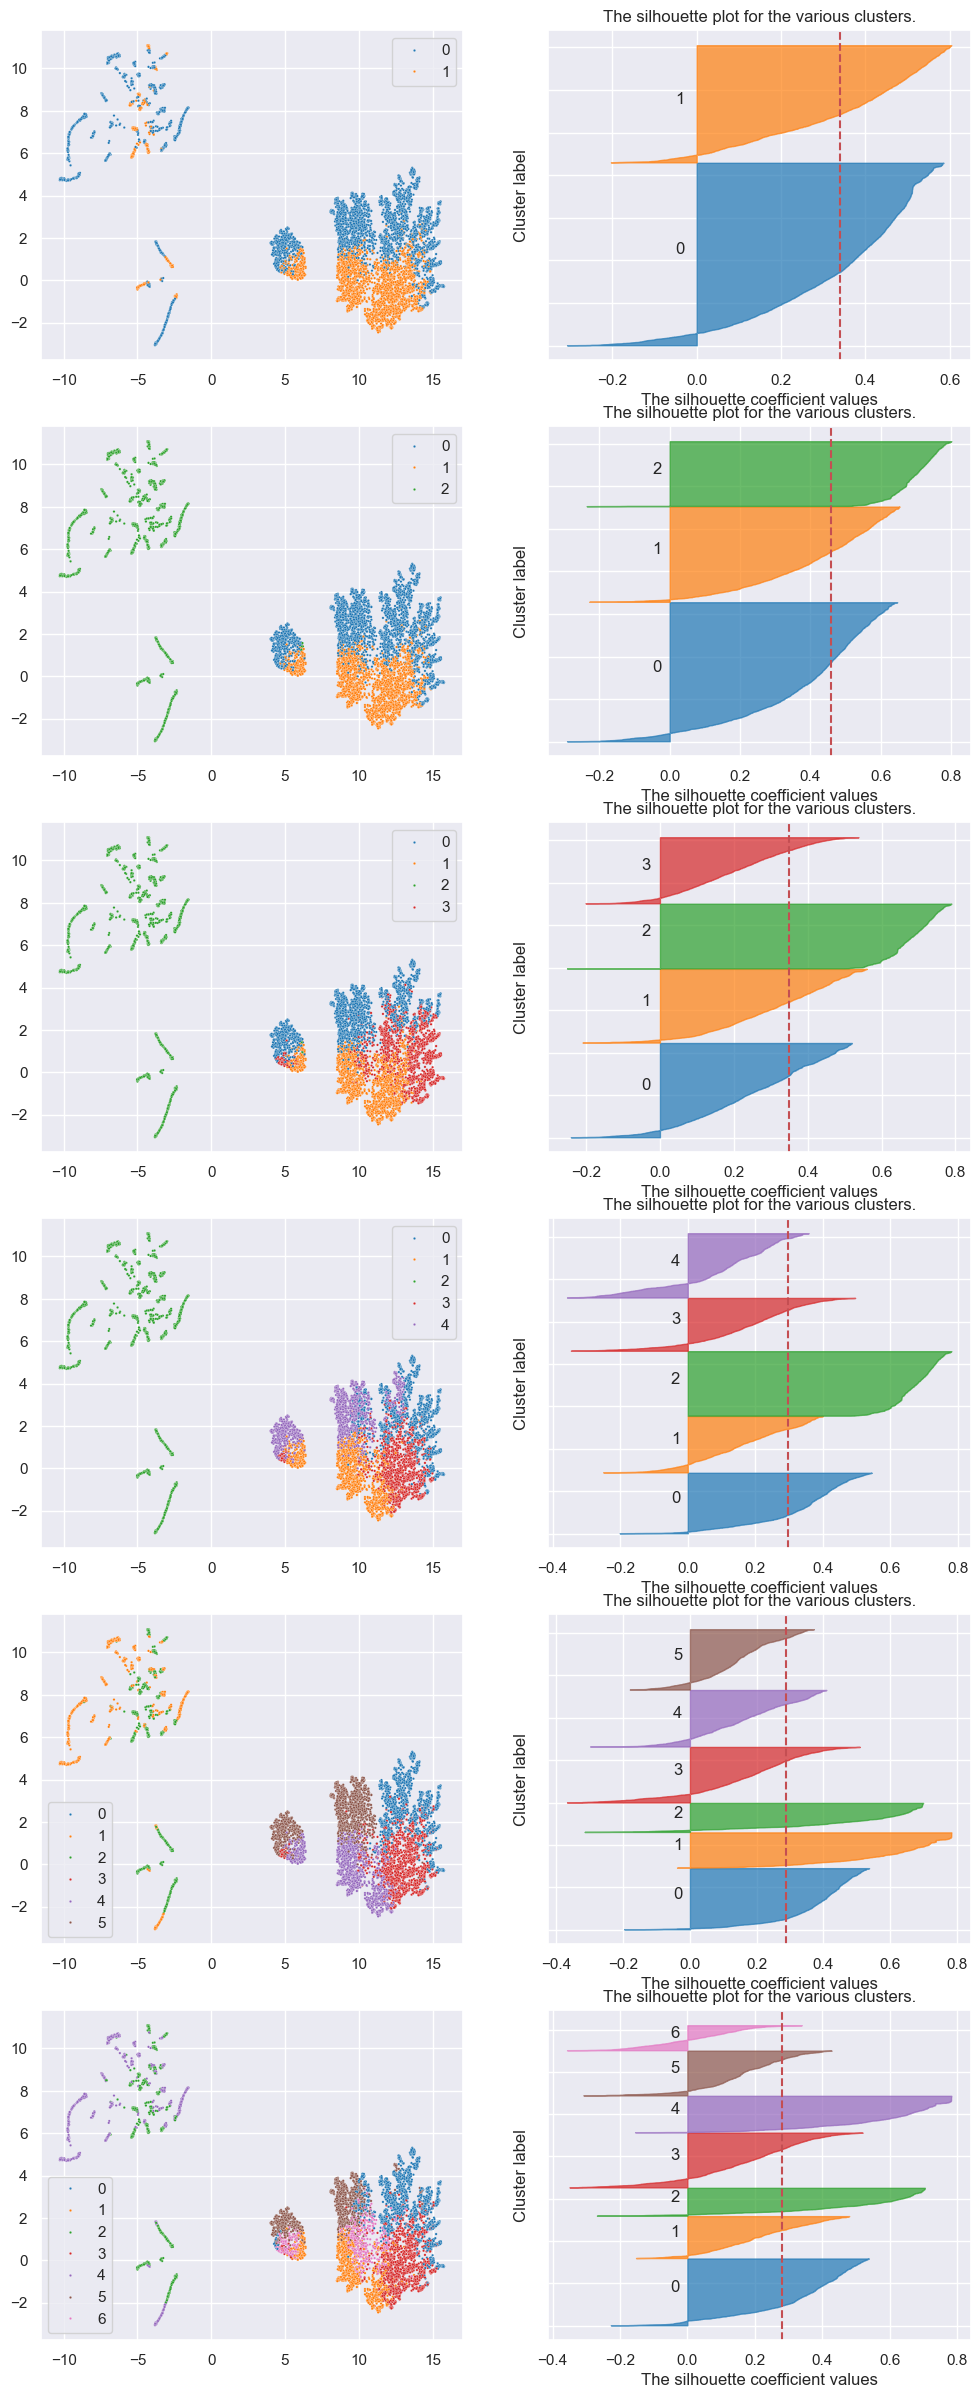

In [45]:
# Perform clustering for multiple values of k
candidate_k = [2,3,4,5,6,7]
tab10 = list(matplotlib.colormaps['tab10'].colors)

cost_list = []
silhouette_list = []

fig, axs = plt.subplots(
    len(candidate_k), 2, 
    figsize=(12, len(candidate_k)*5)
)

cluster_label_dict = {}

for i, num_clust in enumerate(candidate_k):
    
    print('Performing clustering for k = {}'.format(num_clust))
    
    # Perform clustering for current number of clusters
    kproto = KPrototypes(n_clusters=num_clust, init='Cao', n_jobs=8)

    kproto.fit(telco_df.to_numpy(), categorical=list(categ_idx))
    
    sns.scatterplot(
        x=umap_emb_data[:,0], 
        y=umap_emb_data[:,1], 
        hue=kproto.labels_, 
        s=3, palette='tab10',
        ax=axs[i, 0]
    )
        
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    
    curr_silhouette = plot_silouethes_score(
        data=kproto_pairwise,
        clusters=kproto.labels_,
        ax=axs[i, 1],
        distance_measure='precomputed',
        colormap=tab10
    )
    
    cluster_label_dict[num_clust] = kproto.labels_
    cost_list.append(kproto.cost_)
    silhouette_list.append(curr_silhouette)

plt.show()

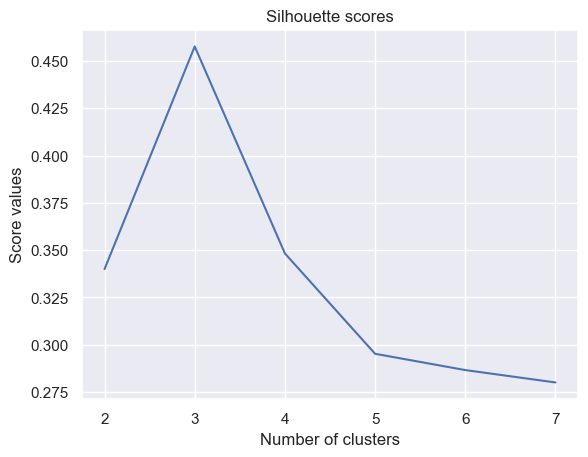

In [46]:
plt.figure()
plt.plot(candidate_k, silhouette_list)
plt.title('Silhouette scores')
plt.xlabel('Number of clusters')
plt.ylabel('Score values')
plt.show()

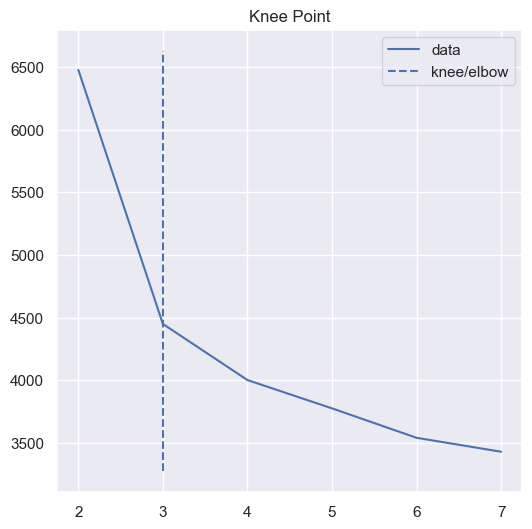

In [47]:
# Use knee locator to find best number of clusters
kneedle = KneeLocator(
    candidate_k, 
    cost_list, 
    S=1.0, 
    curve="convex", 
    direction="decreasing"
)
kneedle.plot_knee()

<Axes: >

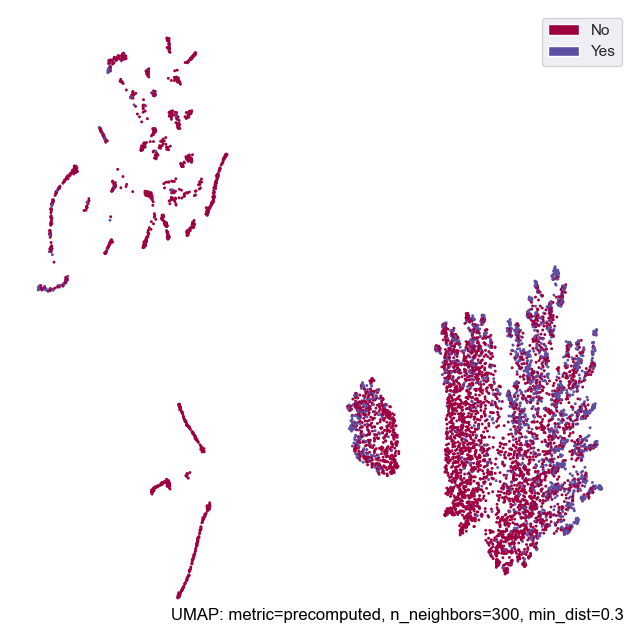

In [48]:
uplot.points(umap_model, labels=original_df['Churn'].to_numpy())

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

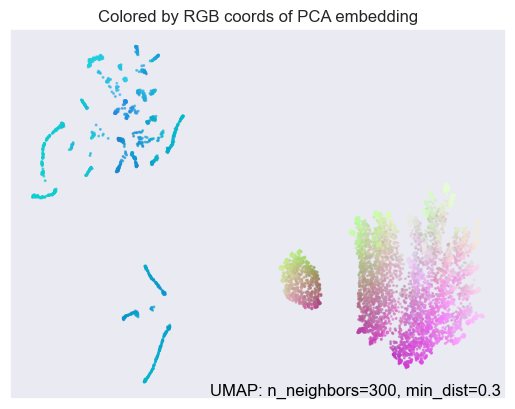

In [49]:
umap.plot.diagnostic(umap_model, diagnostic_type='pca')

In [51]:
cluster_label_dict

{2: array([0, 0, 0, ..., 0, 0, 1], dtype=uint16),
 3: array([0, 0, 0, ..., 0, 0, 1], dtype=uint16),
 4: array([0, 0, 0, ..., 0, 0, 1], dtype=uint16),
 5: array([4, 4, 4, ..., 4, 0, 1], dtype=uint16),
 6: array([5, 5, 5, ..., 5, 0, 4], dtype=uint16),
 7: array([5, 5, 5, ..., 5, 0, 1], dtype=uint16)}

<Axes: >

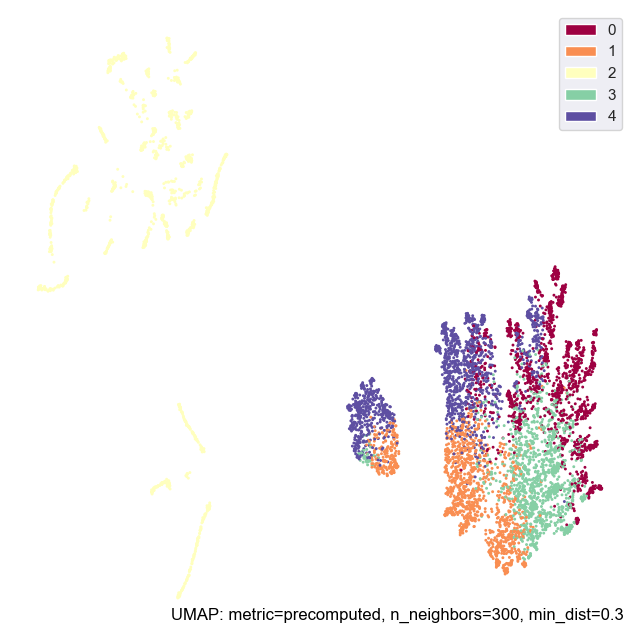

In [50]:
uplot.points(umap_model, labels=cluster_label_dict[5])

In [52]:
# Add cluster info to df
original_df['cluster'] = cluster_label_dict[5]

Cluster Interpretation And Analysis 

In [53]:
original_df['cluster'].value_counts()

cluster
2    1520
4    1515
0    1426
1    1326
3    1245
Name: count, dtype: int64

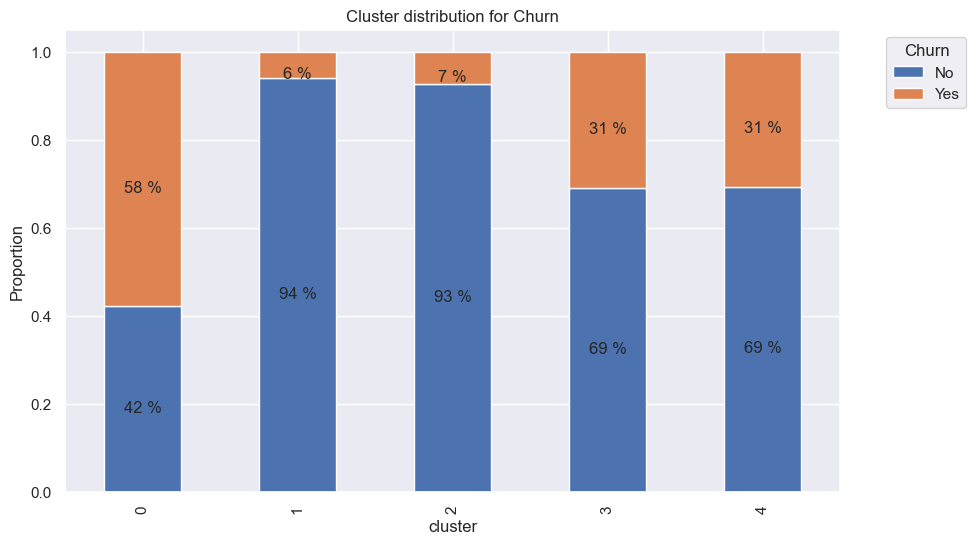

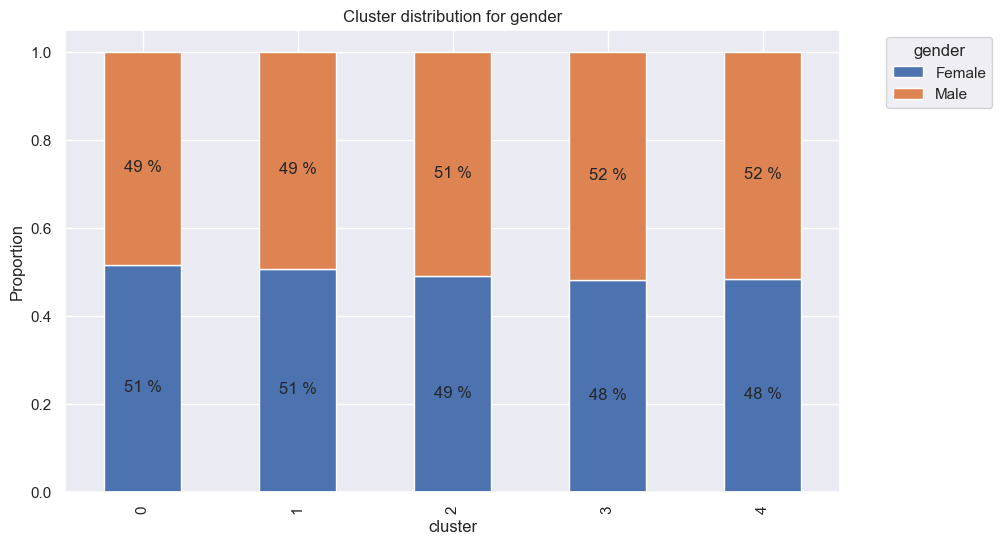

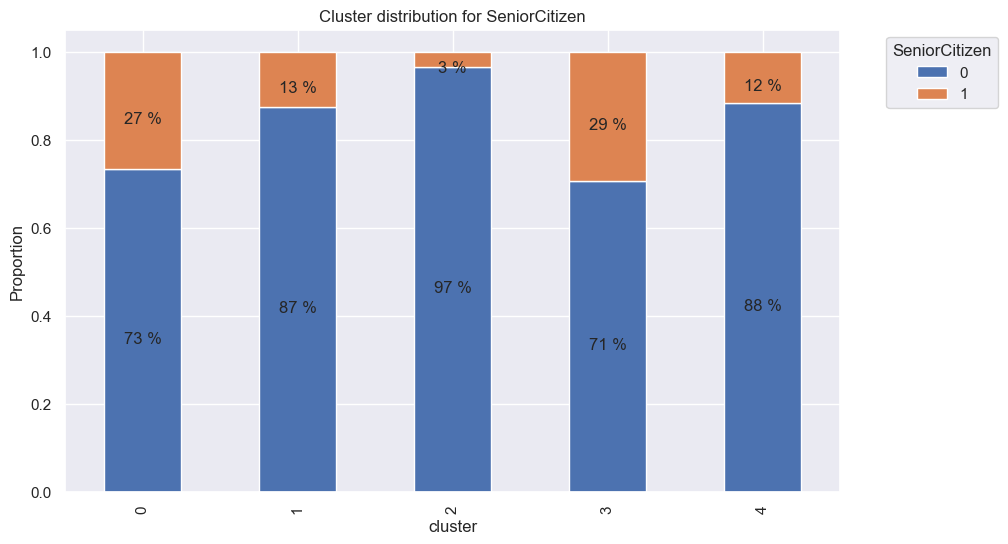

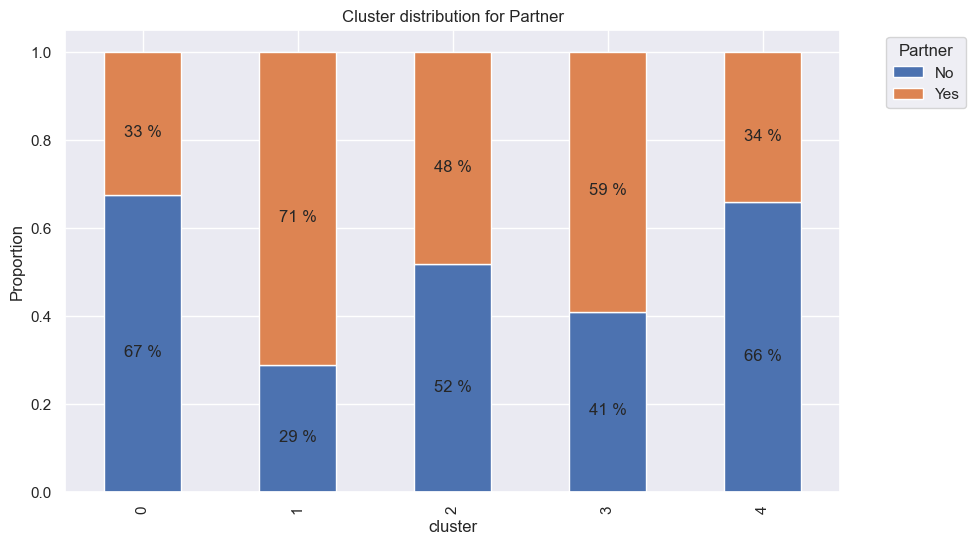

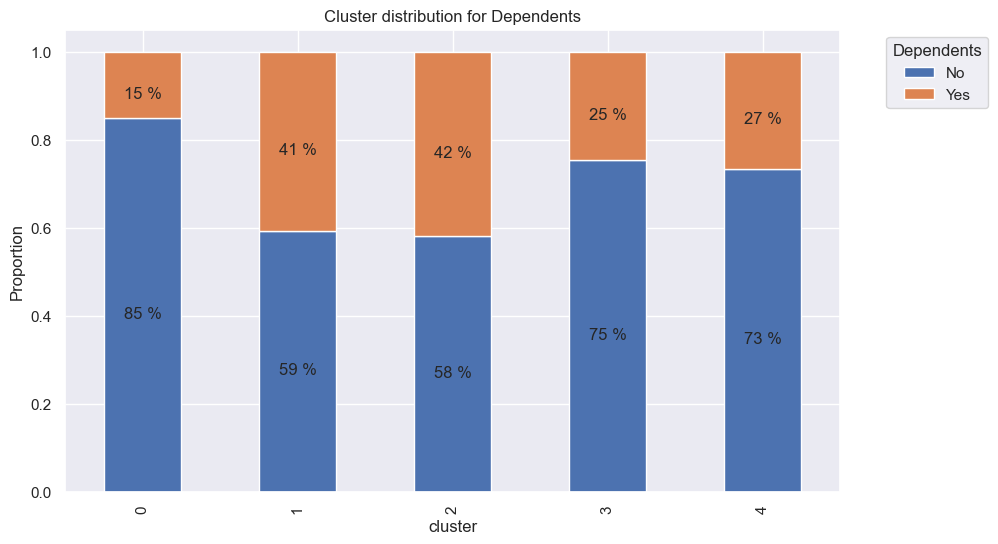

In [54]:
# Plot other categorical data [not used during clustering]
for col in ['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    
    if col != 'cluster':
        
        # Calculate proportions
        proportions = original_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()
                
        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'Cluster distribution for {col}')
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels on the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy() 

                ax.text(x+width/2, 
                        y+height/2, 
                        '\n{:.0f} %'.format(height*100), 
                        horizontalalignment='center', 
                        verticalalignment='center')

        plt.show()

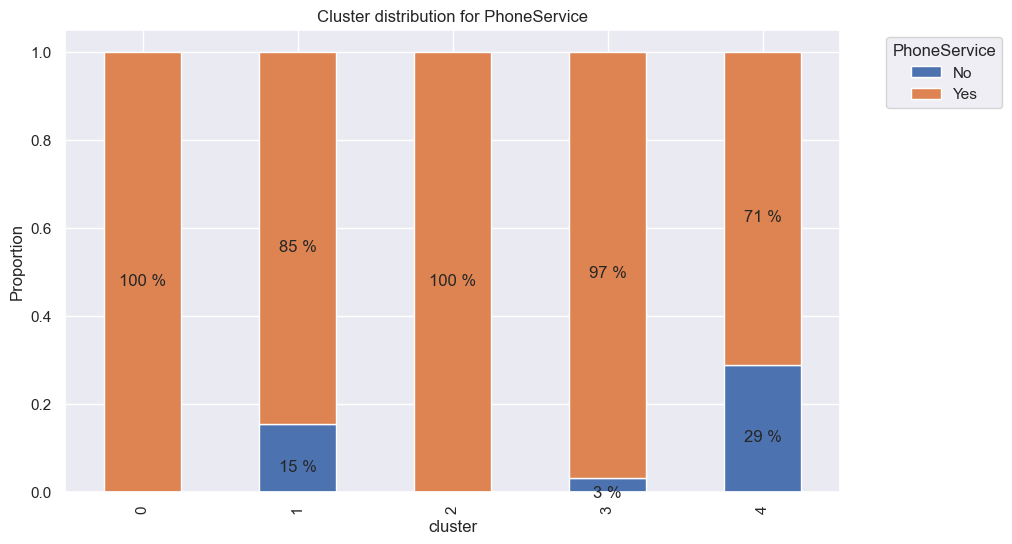

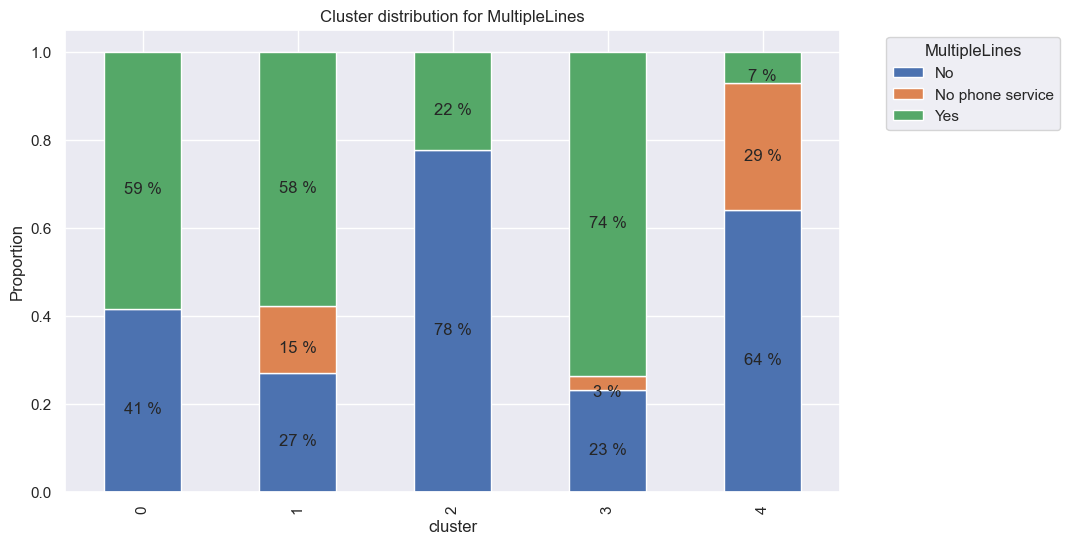

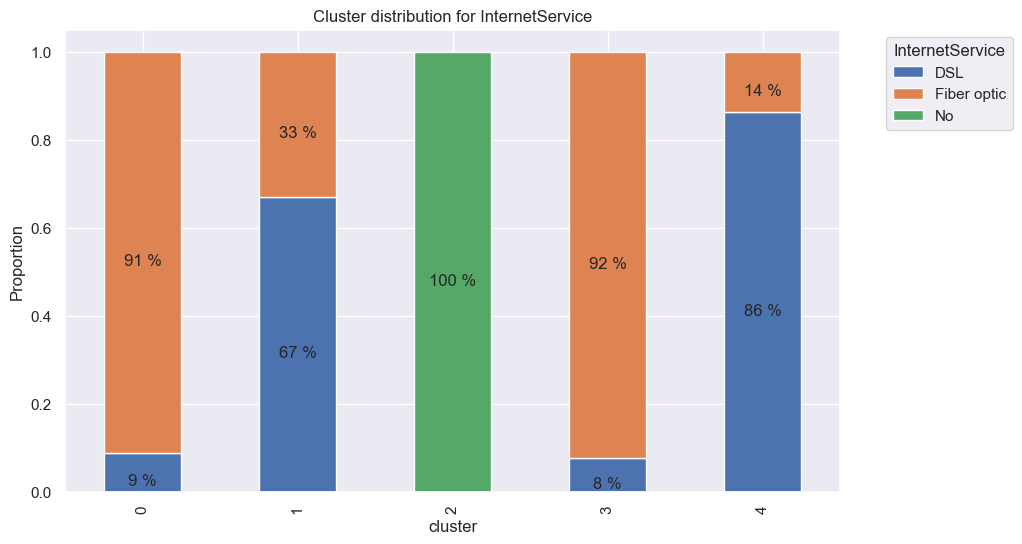

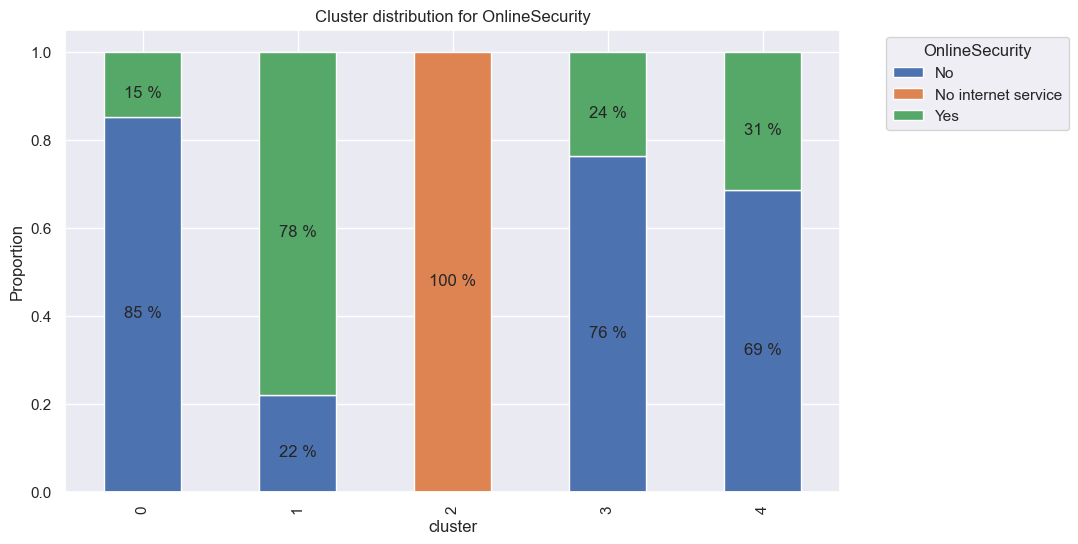

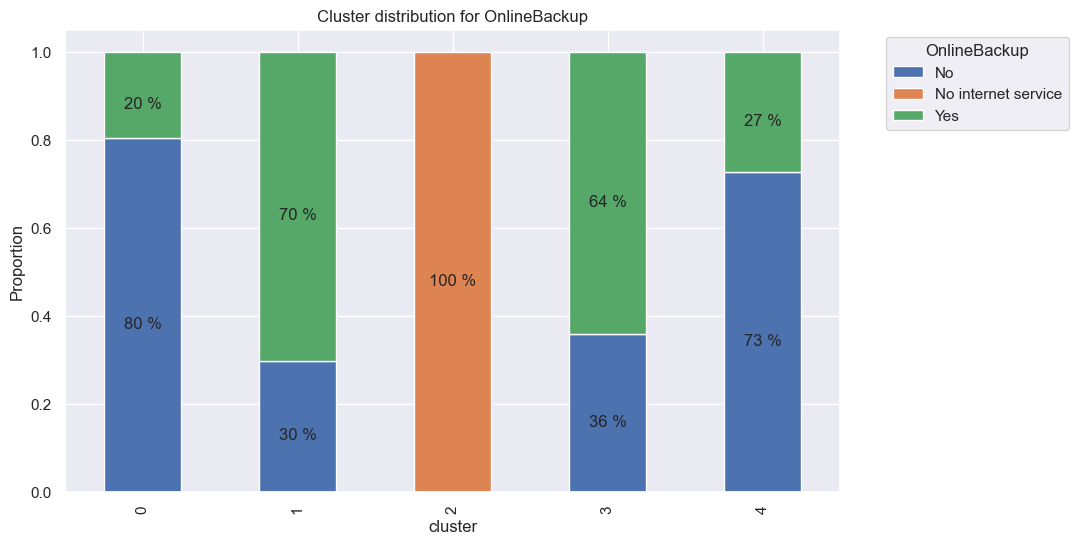

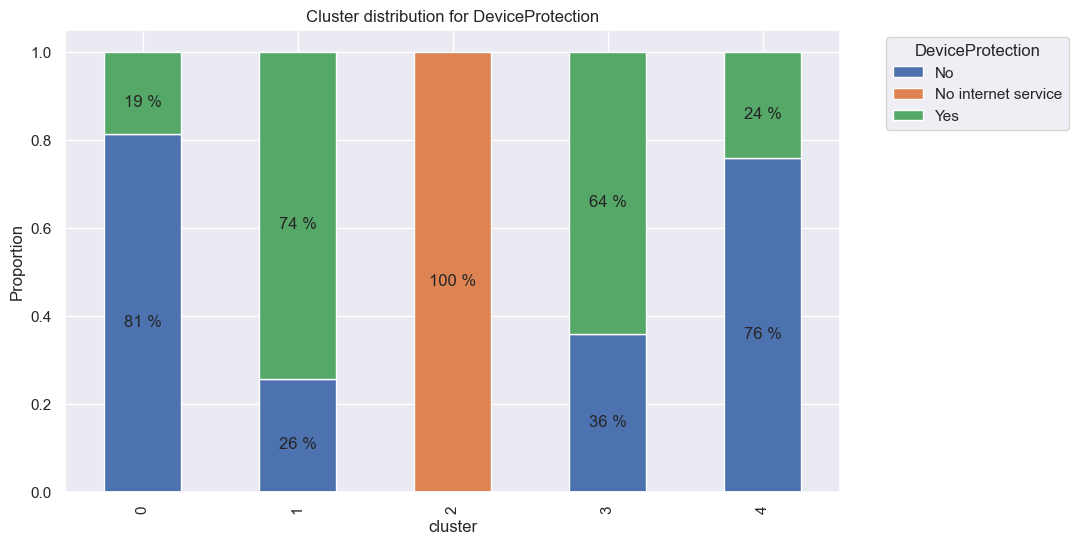

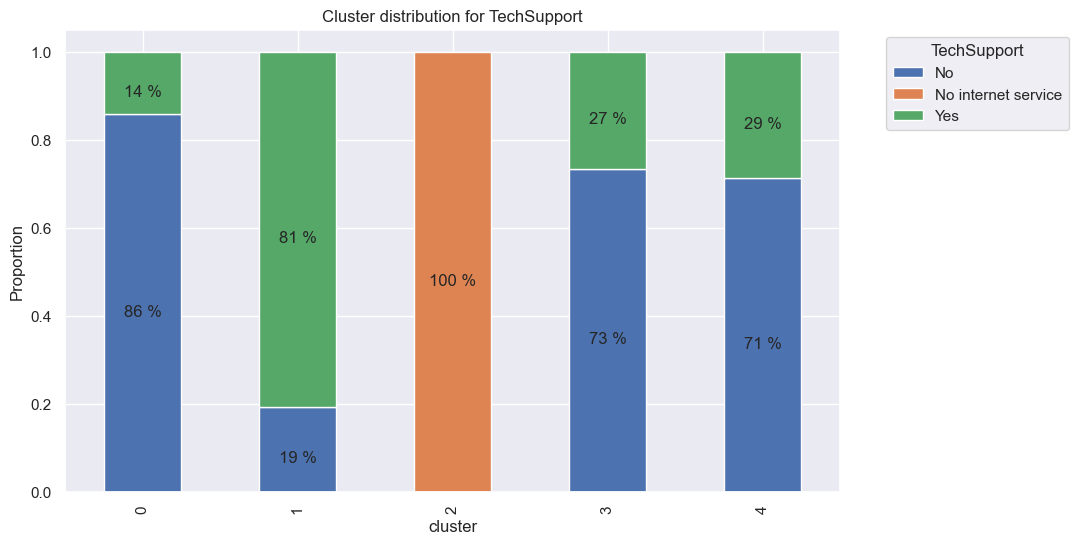

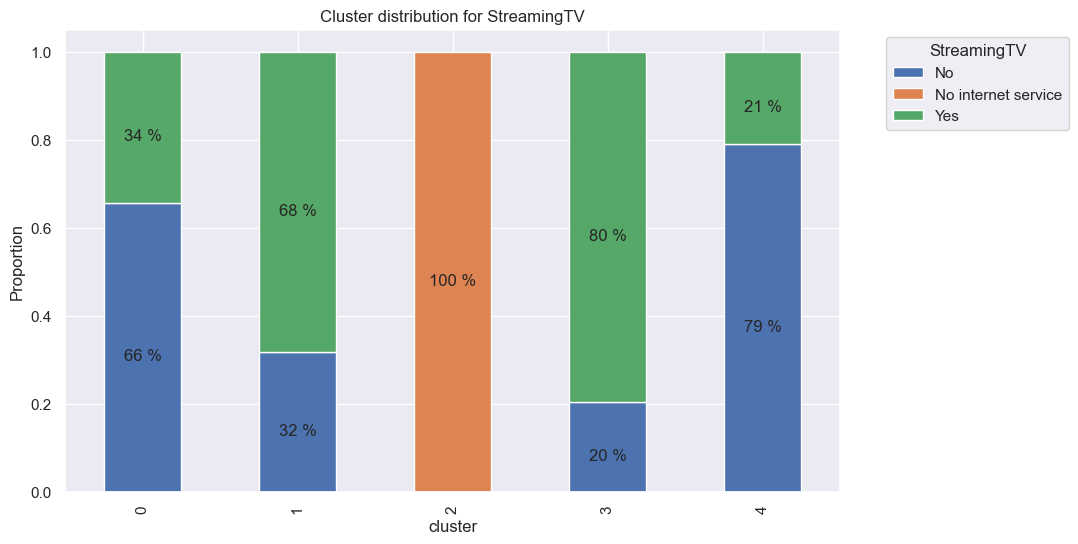

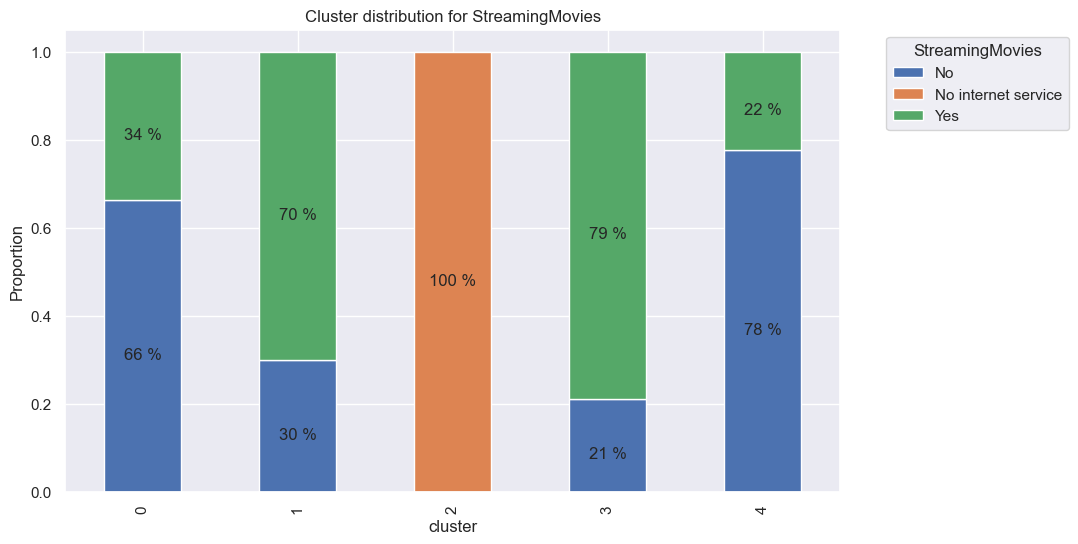

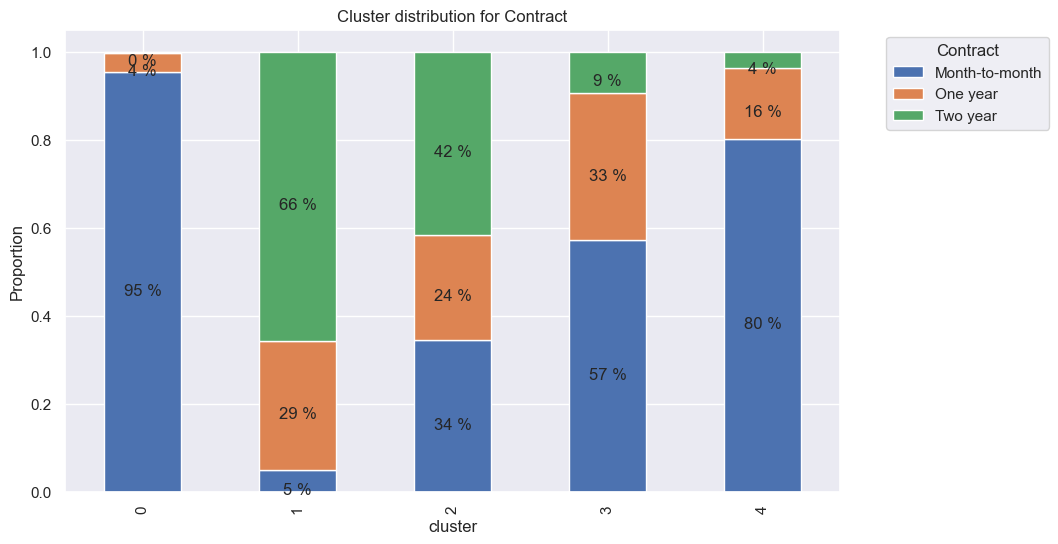

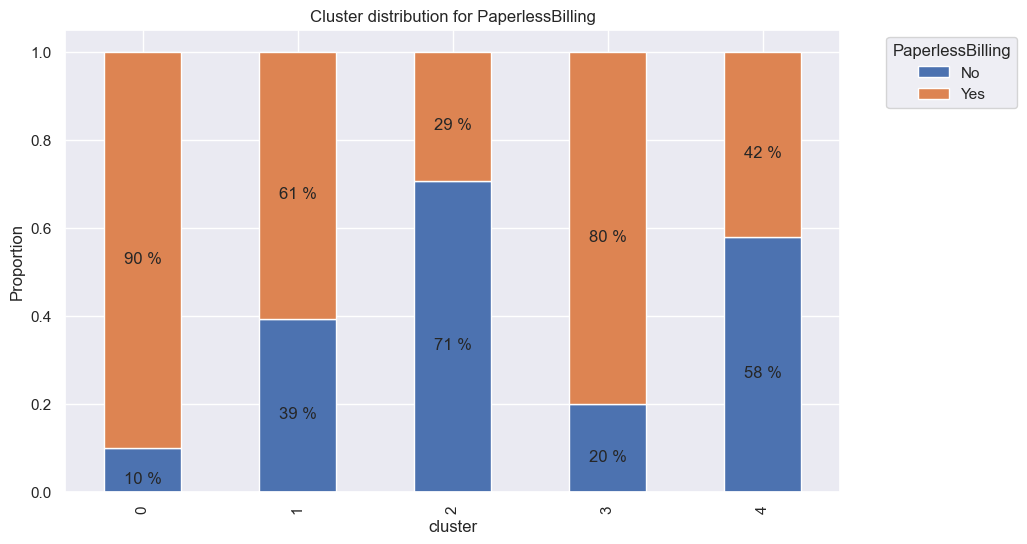

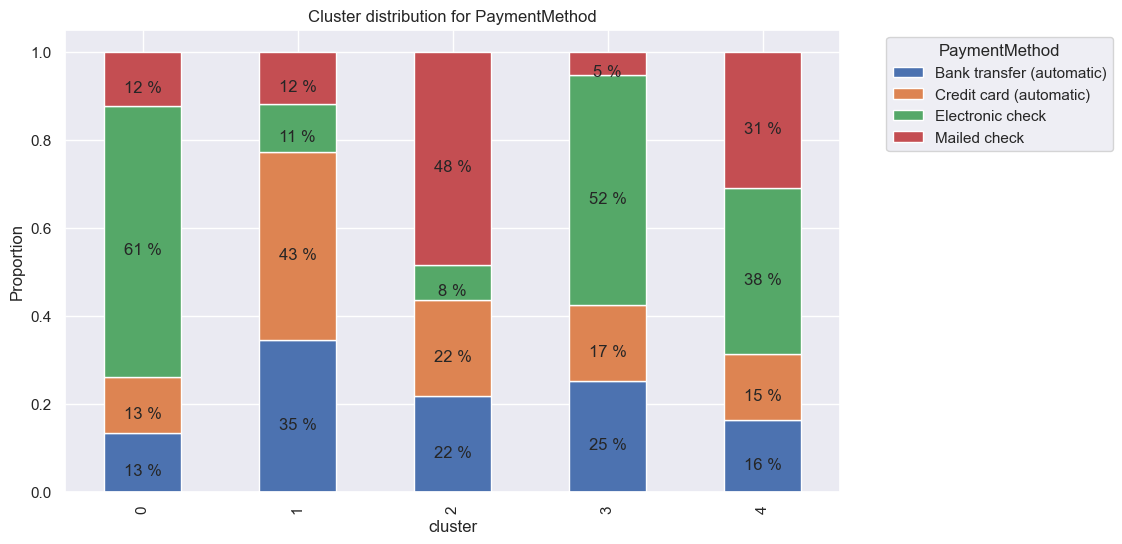

In [55]:
# Categorical plots

for col in categ_cols:
    if col != 'cluster':
        
        # Calculate proportions
        proportions = original_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()
                
        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'Cluster distribution for {col}')
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels on the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy() 

                ax.text(x+width/2, 
                        y+height/2, 
                        '\n{:.0f} %'.format(height*100), 
                        horizontalalignment='center', 
                        verticalalignment='center')

        plt.show()

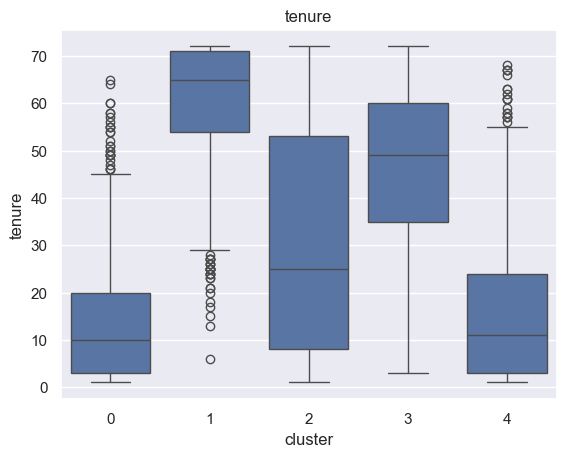

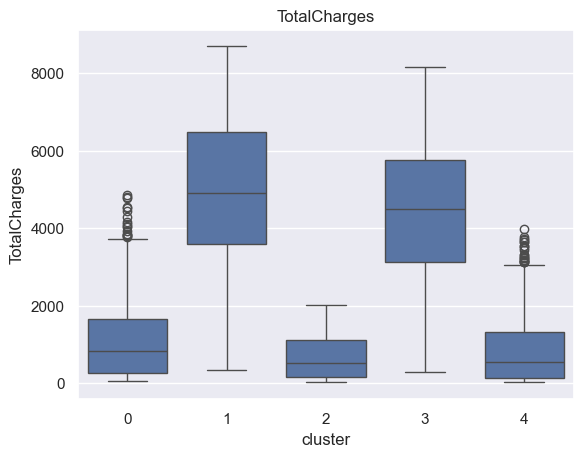

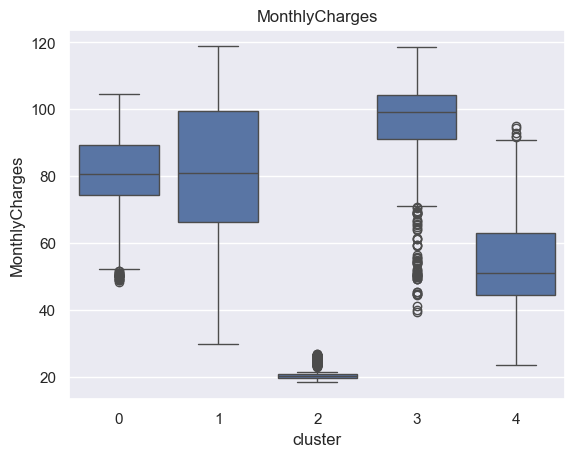

In [56]:
# Plot numerical 
for col in num_cols:
    
    plt.figure()
    sns.boxplot(original_df, x='cluster', y=col)
    plt.title(col)